In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt

results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Add file names to individual DataFrames
df_k['File'] = df_match.Kinect
df_z['File'] = df_match.Zeno

## Visual Results

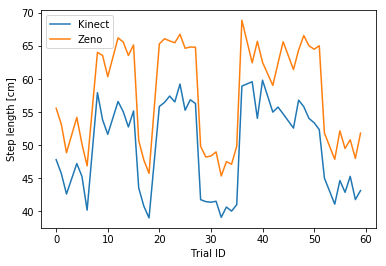

In [2]:
plt.plot(df_k['Step length'])
plt.plot(df_z['Step length'])

plt.xlabel('Trial ID')
plt.ylabel('Step length [cm]')

plt.legend(['Kinect', 'Zeno'])
plt.show()

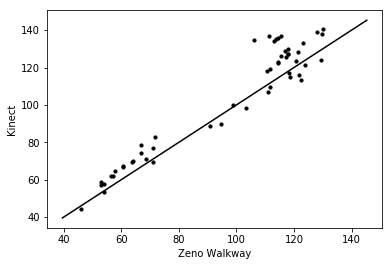

In [3]:
import numpy as np

def compare_measurements(x, y, **kwargs):

    _, ax = plt.subplots()

    ax.scatter(x, y, **kwargs)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

    # Plot both limits against each other
    ax.plot(lims, lims, 'k-')

    
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'Stride vel'
    
compare_measurements(df_z[metric], df_k[metric], c='k', s=10)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

In [4]:
from scipy.stats import spearmanr, pearsonr


In [5]:

def apply_to_columns(df_1, df_2, func):

    df_numeric = df_1.select_dtypes(include='number')

    results_dict = {k: {} for k in df_numeric}

    for col in df_numeric:
        
        results_dict[col] = func(df_1[col], df_2[col])

    return results_dict

In [6]:
import sys
sys.path.append('..')

import modules.stats as st

In [7]:
d = {}
d['Pearson'] = apply_to_columns(df_z, df_k, lambda a, b: pearsonr(a, b)[0])
d['Spearman'] = apply_to_columns(df_z, df_k, lambda a, b: spearmanr(a, b)[0])

d['Abs rel error'] = apply_to_columns(df_z, df_k, lambda a, b: st.relative_error(a, b, absolute=True).mean())

d['Bias'] = apply_to_columns(df_z, df_k, lambda a, b: st.relative_difference(a, b).mean())


df_results = pd.DataFrame(d).T

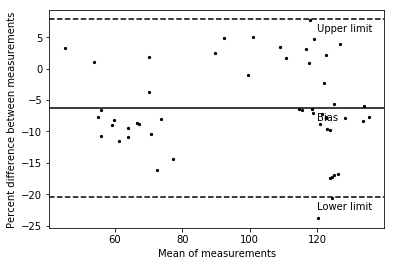

In [8]:
import modules.plotting as pl

metric = 'Stride vel'

means, diffs = st.BlandAltman.differences(df_z[metric], df_k[metric], percent=True)

bias, lower_lim, upper_lim = st.BlandAltman.limits_of_agreement(diffs)

pl.plot_bland_altman(means, diffs, bias, lower_lim, upper_lim, percent=True)

In [9]:
x_min = means.min()
x_max = means.max()

y_min = diffs.min()
y_max = diffs.max()
